In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = "1"></a><br>
## Introduction

This colab is a project for detecting PCB defects.

In the implementation it will use CNN-based model with X-ception architecture.

## Load Libraries


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=74335f0eaafee016e2b6102460367587dff2b35b49055c637bc7234fe7d013fc
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
#basics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tools for accessing and reading data (you do not need to use all of them)
import os
import pathlib
import PIL
import cv2
import skimage
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm

# Tensorflow basics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image


#Lime package for ML explainability
from lime import lime_image

# for reproducibility (does not guarantee fully reproducible results )
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load Data

In [4]:
%cd /content/drive/MyDrive/College/Semester_5/ComputerVision/FINPRO/PCB_Defect_Detection/Dataset/
!ls

/content/drive/MyDrive/College/Semester_5/ComputerVision/FINPRO/PCB_Defect_Detection/Dataset
 archive.zip   dataset.zip  '[Processed]PCB_Data'


In [5]:
!unzip archive.zip -d /content/

Archive:  archive.zip
  inflating: /content/dataset/tobeaugmented/defected/20200707_085703.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_090641.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_091300.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_092157.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_092201.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_092731.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_093001.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_101023.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_101034.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_101039.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_101612.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_103238.jpg  
  inflating: /content/dataset/tobeaugmented/defected/20200707_103242.jpg  
  i

In [6]:
dataset_path = "/content/dataset/tobeaugmented"
defected_path = "/content/dataset/tobeaugmented/defected"
non_defected_path = "/content/dataset/tobeaugmented/non-defect"

print(f"Defected Images:{len(os.listdir(defected_path))}")
print(f"Non-Defected Images:{len(os.listdir(non_defected_path))}")

Defected Images:101
Non-Defected Images:285


## Data and Parameter Preparation

In [7]:
batch_size = 64
epochs=100
img_height = 286
img_width = 286
img_size = (img_height, img_width)

In [8]:
train_set = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    labels='inferred',
    class_names = ['defected', 'non-defect'],
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 386 files belonging to 2 classes.
Using 309 files for training.


In [9]:
val_set = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    labels='inferred',
    class_names = ['defected', 'non-defect'],
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 386 files belonging to 2 classes.
Using 77 files for validation.


Checking the Data

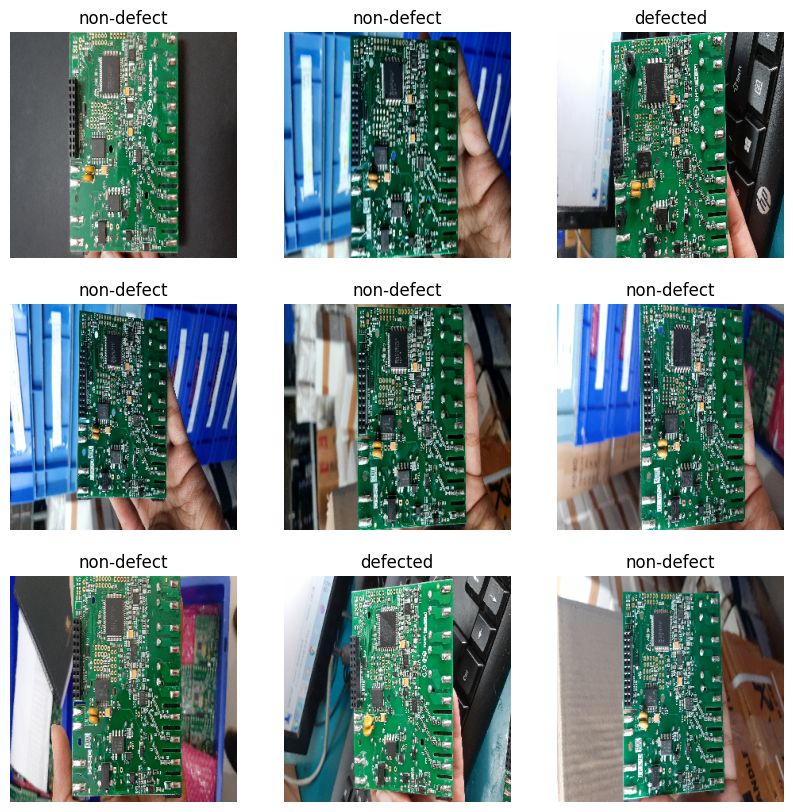

In [10]:
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for images, labels in train_set:
  print(images.shape)
  print(labels.shape)
  break

(64, 286, 286, 3)
(64,)


<a id = "4"></a><br>
## Efficient Input Pipelines

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

<a id = "5"></a><br>
## Data Augmentation

I decided to use the following ones:

* Random flip: All sample images may not be taken same oriantation, so we can flip the images both on the horizontal and vertical axis
* Random zoom: Some of the images are zoomed. We can also add random zoomed versions of all samples to the training set
* Random contrast: Some images are darker than others. Let's add some random contrast.

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3), seed = seed ),
    layers.RandomZoom(0.1, seed = seed ),
    layers.RandomContrast(0.3, seed = seed  )
  ]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<a id = "6"></a><br>
## Building a Custom Model

Okay, we take care of everything regarding our data. Let's create our model.


In [14]:
custom_model = Sequential([

  layers.Rescaling(1./255),
  data_augmentation,

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [15]:
custom_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

<a id = "7"></a><br>
## Callbacks

Before training, we can construct some callbacks. I used two callbacks here:

* A custom callback to stop the learning process when a desired accuracy is reached
* A callback to control the learning rate during training.

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0 :
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback =  myCallback()

In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,min_delta=0.01,
                              patience=5, min_lr=0.000001)



<a id = "8"></a><br>
## Custom Model Performance

Let's train our model.

In [18]:
history1 = custom_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=epochs,
                               callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6987 - loss: 0.6394 - val_accuracy: 0.7532 - val_loss: 0.5213 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.7155 - loss: 0.5686 - val_accuracy: 0.7532 - val_loss: 0.4514 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.7333 - loss: 0.4721 - val_accuracy: 0.8961 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.8827 - loss: 0.3480 - val_accuracy: 0.8961 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9127 - loss: 0.2924 - val_accuracy: 0.8831 - val_loss: 0.3239 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9318 - loss: 0.2229 - val_accuracy: 0.9870 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.9366 - loss: 0.1321 - val_accur

In [19]:
custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 286, 286, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 286, 286, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 286, 286, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 143, 143, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 143, 143, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 71, 71, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 35, 35, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,183,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,834,341 (14.63 MB)

 Trainable params: 1,278,113 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,556,228 (9.75 MB)

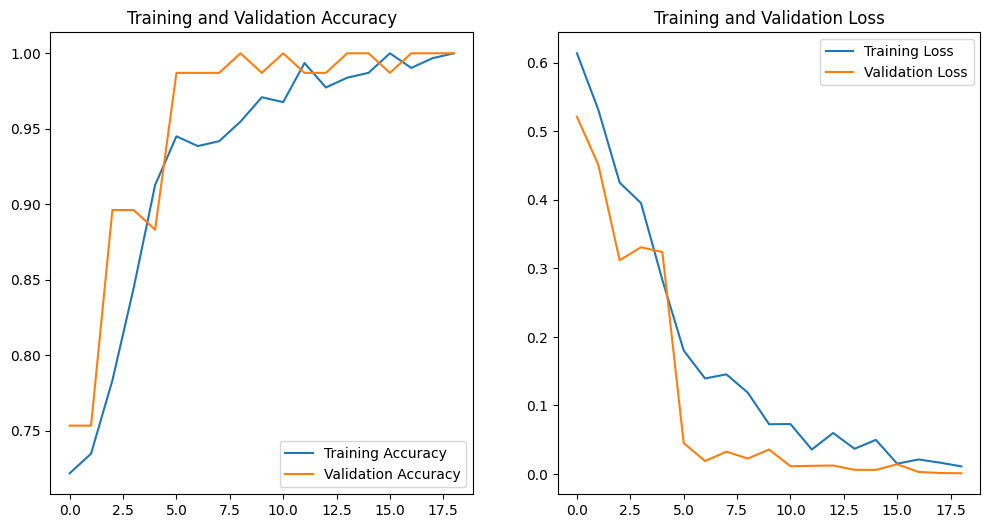

In [20]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We get a 100% accuracy both on training and validation sets.

<a id = "9"></a><br>
## Transfer Learning with Xception

Early layers of CNN models behave like feature extractors. Since pre-trained models are trained on large data sets, they already have rich feature representations of different objects. Those features could also help us when we have a small amount of data.

Xception is one of that pre-trained models and I will use it here.



In [21]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I decided to use the functional API instead of the sequential one here. This choice has no special point; you can also construct the model using sequential API. I just wanted to mention it and show its syntax.

In [22]:
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)  # Apply random data augmentation

x = keras.layers.Rescaling(scale=1 / 255.0)(x)

x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
pretrained_model = keras.Model(inputs, outputs)

In [23]:
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [24]:
history2 = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5330 - loss: 12.8208 - val_accuracy: 0.4286 - val_loss: 2.2015 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 597ms/step - accuracy: 0.8738 - loss: 0.3739 - val_accuracy: 0.9740 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.9205 - loss: 0.2625 - val_accuracy: 0.9870 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - accuracy: 0.9942 - loss: 0.0249 - val_accuracy: 0.9221 - val_loss: 0.1925 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.9777 - loss: 0.1049 - val_accuracy: 0.9870 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 598ms/step - accuracy: 0.9921 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 7.2383e-04 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.9880 - loss: 0.0374 - val_

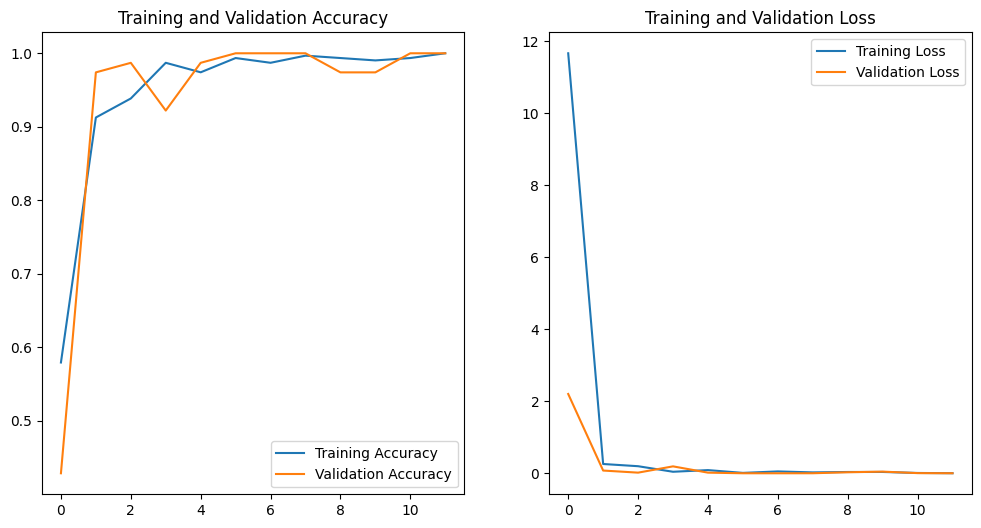

In [25]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
pretrained_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 286, 286, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 286, 286, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 286, 286, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 9, 9, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 165888)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      21,233,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,563,245 (322.58 MB)

 Trainable params: 21,233,921 (81.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 42,467,844 (162.00 MB)

We again get a 100% accuracy both on training and validation sets with less epochs.

<a id = "10"></a><br>
## Model Explainability

Model explainability is vital to convince people that our model is working fine and its attention is at the correct place. I will use LIME package here.


In [34]:
# The path to our target image
img_path = '/content/dataset/tobeaugmented/defected/20200707_160659.jpg'
display(Image(img_path))


Output hidden; open in https://colab.research.google.com to view.

In [35]:
def read_and_transform_img(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (img_height,img_width))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

In [41]:
images = read_and_transform_img(img_path)

preds = custom_model.predict(images)
# preds = pretrained_model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


In [48]:
if prediction == 0:
    print("defected")
else:
    print("non_defected")

print(f"{pct:.2f}")

defected
0.00


<a id = "12"></a><br>
## LIME

In [43]:
explainer = lime_image.LimeImageExplainer()


In [44]:
explanation = explainer.explain_instance(images[0].astype('double'), custom_model.predict,
                                        top_labels=2, hide_color=0, num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

(-0.5, 285.5, 285.5, -0.5)

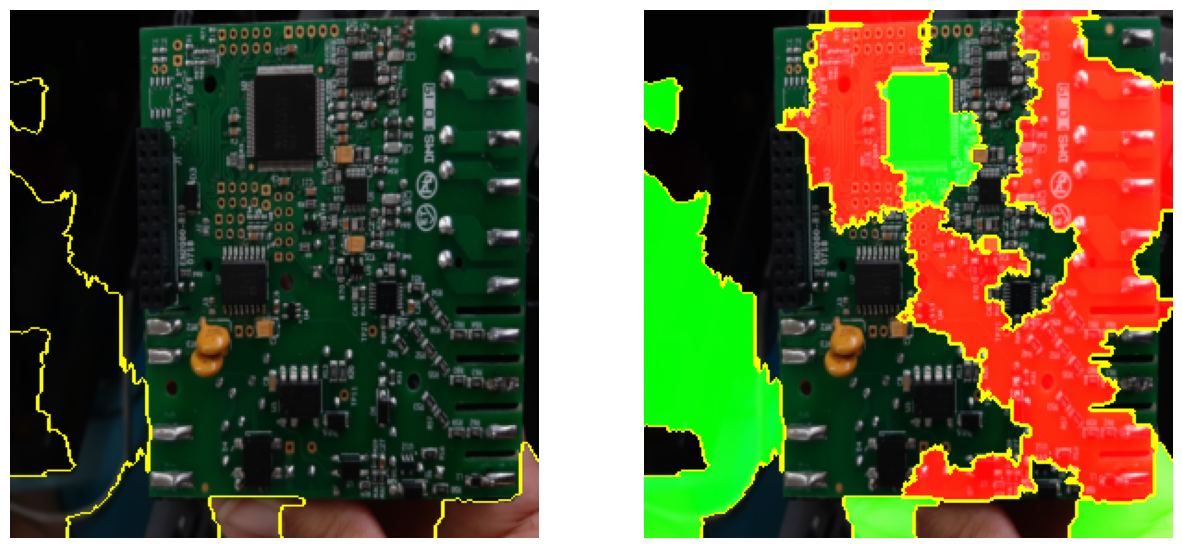

In [45]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')